In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import seaborn as sns
import json
import torch
import pickle

import matplotlib
matplotlib.rcParams.update({'font.size': 14})
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DeJavu Serif"


In [2]:
df_all = pd.DataFrame()

In [3]:
perp_folders = ["../output/08022024/"]

In [4]:

for perp_folder in perp_folders:
    files = os.listdir(perp_folder)
    files = [os.path.join(perp_folder, f) for f in files] # add path to each file
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    
    for file in files:        
        if "opposite" in file or "emb" in file or "predictions" in file or "proportions" in file:
            continue 
        
        if "english" not in file:
            continue 
                
        if ".log" in file:
            continue
        print(file)
        method = file.split("/")[-1]
        
        runs = os.listdir(file)
        
        for run in runs:
            if "proportions" in run:
                continue 
            seed = int(run.split("seed_")[-1].split("_")[0])
            checkpoint = int(run.split("-")[-1].split(".")[0])
            if len(df_all) != 0:
                if len(df_all.loc[(df_all.method==method) & (df_all.seed == seed) & (df_all.index==checkpoint)]) != 0:
                    continue 
                
            path = os.path.join(file, run)
            print(path)
                
            loss_dict = pd.read_pickle(path)
        
        
            df = pd.DataFrame([{"skill": k, "loss": [values.numpy() if torch.is_tensor(values) else values for values in v]} for k, v in loss_dict.items()])
            df["perplexity"] = pd.Series([np.exp(l) for l in df["loss"].values])
            df["average_loss"] = pd.Series([sum(l)/len(l) for l in df["loss"].values])
            df["average_perplexity"] = pd.Series([sum(p)/len(p) for p in df["perplexity"].values])
            df["method"] = method
            df["seed"] = seed
            df["checkpoint"] = checkpoint


            df.set_index("checkpoint", inplace=True)


            df_all = pd.concat([df_all, df])
    


../output/5050/ni_xlingual_600_mixture_question_answering_english_english_question_answer_weights_0000_static
../output/5050/ni_xlingual_600_mixture_question_answering_english_english_question_answer_weights_0000_static/seed_3_checkpoint-0.pkl
../output/5050/ni_xlingual_600_mixture_question_answering_english_english_question_answer_weights_0000_static/seed_1_checkpoint-0.pkl
../output/5050/ni_xlingual_600_mixture_question_answering_english_english_question_answer_weights_0000_static/seed_2_checkpoint-100.pkl
../output/5050/ni_xlingual_600_mixture_question_answering_english_english_question_answer_weights_0000_static/seed_0_checkpoint-500.pkl
../output/5050/ni_xlingual_600_mixture_question_answering_english_english_question_answer_weights_0000_static/seed_3_checkpoint-600.pkl
../output/5050/ni_xlingual_600_mixture_question_answering_english_english_question_answer_weights_0000_static/seed_0_checkpoint-0.pkl
../output/5050/ni_xlingual_600_mixture_question_answering_english_english_questi

In [19]:
def aggregate_skill(x, ppl=True):
    if ppl:
        total_ppl = x["perplexity"].apply(lambda x: sum(x)).sum()
        count_ppl = x["perplexity"].apply(lambda x: len(x)).sum()
        metric_name = "skill_perplexity"
        metric = total_ppl/count_ppl
    else:
        total_loss = x["loss"].apply(lambda x: sum(x)).sum()
        count_loss = x["loss"].apply(lambda x: len(x)).sum()
        metric_name = "skill_loss"
        metric = total_loss/count_loss

    names = {metric_name: metric}
    
    return pd.Series(names, index=[metric_name])



In [20]:
sorted(df_all.method.unique())

['ni_xlingual_600_mixture_question_answering_english_english_question_answer_targetmask_0001_mean_spanish_qg_normalized_greedy_100_eta_0.8_lookback_3_checkpoints']

[3 4 0 2 1]
checkpoint
600    2.716817
600    2.289134
600    2.873718
600    2.327511
Name: skill_loss, dtype: float64


/tmp/ipykernel_1123986/720742971.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_shuffled = df_shuffled.groupby([df_shuffled.index, "skill"]).apply(lambda x: aggregate_skill(x, ppl=False)).reset_index()


Text(0.5, 1.0, 'Targeted learning of Spanish question generation')

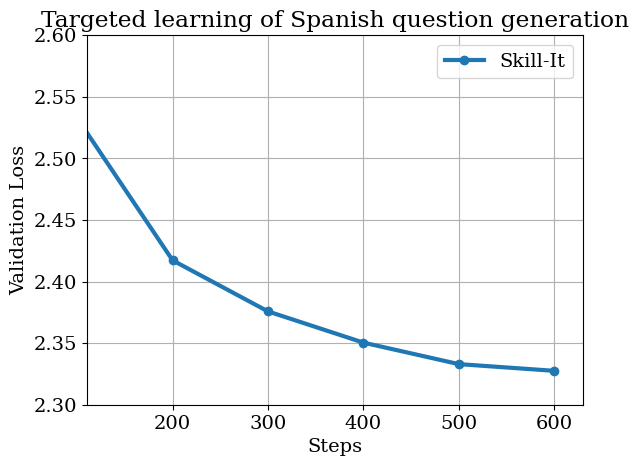

In [22]:


# methods = ["ni_xlingual_600_mixture_question_answering_english_english_question_answer_weights_0001_static",
#            "ni_xlingual_600_stratified_question_answering_english_english_question_answer_static",
#            "ni_xlingual_600_mixture_question_answering_english_english_question_answer_targetmask_0001_mean_spanish_qg_normalized_greedy_100_eta_0.8_lookback_3_checkpoints"
# ]
methods = ["ni_xlingual_600_mixture_question_answering_english_english_question_answer_targetmask_0001_mean_spanish_qg_normalized_greedy_100_eta_0.8_lookback_3_checkpoints"]
plt.figure()
seeds=[0, 1, 2, 3, 4]

labels = ["Skill-It"]

for i, method in enumerate(methods):
    
    df_shuffled = df_all.loc[df_all.method == method].sort_index()
    print(df_shuffled.seed.unique())
    df_shuffled = df_shuffled.loc[df_shuffled.seed.isin(seeds)]
    df_overall = df_shuffled.groupby([df_shuffled.index]).apply(lambda x: aggregate_skill(x, ppl=False)).reset_index()
    df_shuffled = df_shuffled.groupby([df_shuffled.index, "skill"]).apply(lambda x: aggregate_skill(x, ppl=False)).reset_index()
    df_shuffled.set_index("checkpoint", inplace=True)
    df_overall.set_index("checkpoint", inplace=True)
    df_overall.drop([0], inplace=True)

    df_shuffled.loc[df_shuffled.skill == "question_generation_spanish_spanish"].skill_loss.plot(marker="o", label=labels[i], lw=3)
    print(df_shuffled.loc[df_shuffled.index == df_shuffled.index.max()].skill_loss)



plt.xlim(110, )
plt.ylim(2.3, 2.6)
plt.xlabel("Steps")
plt.ylabel("Validation Loss")
plt.legend(loc='upper right')
plt.grid()
plt.title("Targeted learning of Spanish question generation")


In [23]:
df_all[df_all['skill'] == "question_generation_spanish_spanish"].sort_values(by=["checkpoint", "seed"])

,skill,loss,perplexity,average_loss,average_perplexity,method,seed
checkpoint,,,,,,,
0,question_generation_spanish_spanish,"[2.8070033, 3.0850577, 2.637026, 2.7888188, 2....","[16.560217, 21.868729, 13.97159, 16.2618, 9.02...",2.912263,19.194009,ni_xlingual_600_mixture_question_answering_eng...,0
0,question_generation_spanish_spanish,"[2.843722, 3.203541, 2.6426663, 2.8948762, 2.7...","[17.179592, 24.619555, 14.050618, 18.081264, 1...",2.914565,19.233102,ni_xlingual_600_mixture_question_answering_eng...,1
0,question_generation_spanish_spanish,"[2.8436024, 2.3155189, 2.973291, 2.9557693, 2....","[17.177536, 10.1301775, 19.556173, 19.216501, ...",2.912307,19.262130,ni_xlingual_600_mixture_question_answering_eng...,2
0,question_generation_spanish_spanish,"[2.8359587, 3.229113, 2.670998, 3.0162997, 2.9...","[17.046736, 25.257246, 14.454388, 20.41561, 18...",2.911948,19.095407,ni_xlingual_600_mixture_question_answering_eng...,3
0,question_generation_spanish_spanish,"[2.5366051, 2.4074004, 2.67908, 2.7951238, 2.7...","[12.636698, 11.105055, 14.571681, 16.364655, 1...",2.911162,19.298344,ni_xlingual_600_mixture_question_answering_eng...,4
100,question_generation_spanish_spanish,"[2.598296, 2.5780525, 2.4651442, 2.5749683, 1....","[13.440814, 13.171462, 11.765178, 13.130902, 6...",2.508443,12.826113,ni_xlingual_600_mixture_question_answering_eng...,0
100,question_generation_spanish_spanish,"[2.6956365, 2.814737, 2.3063085, 2.4506495, 2....","[14.814947, 16.688787, 10.037304, 11.595875, 1...",2.542855,13.255961,ni_xlingual_600_mixture_question_answering_eng...,1
100,question_generation_spanish_spanish,"[2.3579783, 1.9453945, 2.379537, 2.3368716, 2....","[10.569562, 6.9963913, 10.799903, 10.348811, 8...",2.509287,12.856494,ni_xlingual_600_mixture_question_answering_eng...,2
100,question_generation_spanish_spanish,"[2.3411198, 3.0448625, 2.1068025, 2.5974653, 2...","[10.392867, 21.007141, 8.2219095, 13.429654, 1...",2.563983,13.636184,ni_xlingual_600_mixture_question_answering_eng...,3


In [24]:
df_all[df_all.index == 600].sort_values(by=["checkpoint", "seed"]).groupby("skill").agg({"average_loss": "mean"})

,average_loss
skill,
question_answering_english_english,2.716828
question_answering_spanish_spanish,2.289105
question_generation_english_english,2.873746
question_generation_spanish_spanish,2.327764
